<a href="https://colab.research.google.com/github/inwe-boku/lecture-scientific-programming-private/blob/main/toilett_gender_balance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
FIGSIZE = (12, 12)  # used later for changing figure size

# Toilett Gender Balance Vienna

We use this data set: *Public toilets in Vienna*: https://www.data.gv.at/katalog/dataset/d9f5e582-3773-4f0b-8403-5d34718f6cf7


Inspired by this article: https://www.moment.at/story/warteschlange-vor-dem-frauenklo/

## Download and read data

In [ ]:
import urllib
import os.path
from pathlib import Path
import pandas as pd

def read_public_toilets():
    """Download CSV with geocordinates of public toilets in Vienna, parse it and return a numpy
    array of shape (N,2), where each point is (longitude_x, latitude_y)."""
    fname = 'public-toilets.csv'
    if not os.path.exists(fname):
        URI = ('https://data.wien.gv.at/daten/geo?'
               'service=WFS&request=GetFeature&version=1.1.0&'
               'typeName=ogdwien:WCANLAGE2OGD&srsName=EPSG:4326&outputFormat=csv')
        urllib.request.urlretrieve(URI, filename=fname)

    d = pd.read_csv(fname)
    coords = d.SHAPE.str.extract(r'POINT \((\d+\.\d+) (\d+\.\d+)\)').astype(float).values

    # Note: we use the order (longitude, latitude) here. This is the order used in shape files and necessary for plotting too.
    d['coord_x'] = coords.T[0]
    d['coord_y'] = coords.T[1]

    return d

In [ ]:
public_toilets = read_public_toilets()

In [ ]:
category = public_toilets.KATEGORIE

In [ ]:
def count_gender(gender_str):
  if gender_str.strip() == 'Herren1':
    return 'Herren', 1
  if gender_str.strip() == 'Damen1':
    return 'Damen', 1

  values = gender_str.strip().rsplit(' ', 1)
  if len(values) == 1:
    # number seems to be missing
    gender = values[0]
    count = 1
  else:
    gender, count = values
  return gender, int(count)


In [ ]:
def stringlist_to_dict(gender_stringlist):
  """
  """
  return dict([count_gender(genderstring) for genderstring in gender_stringlist])

In [ ]:
list_of_dict = [stringlist_to_dict(gender_stringlist)
  for gender_stringlist
  in category
                .fillna('')
                .str.replace(':', ';')     # seems to be typo
                .str.replace('1 ', '1;')   # probably a missing ';'
                .str.replace('Unisex', 'unisex')
                .str.replace('Pissior', 'Pissoir')
                .str.replace('unisex barrierefrei 1', 'unisex 1; barrierefrei 1')

                # just guessing that this is the right way to interpete this...
                .str.replace('Damen/barrierefrei 1', 'Damen 1; barrierefrei 1')
                .str.split(';')

]

In [ ]:
gender_balance = pd.DataFrame(list_of_dict).fillna(0)

## Data

Each row in `gender_balance` represents one toilet location and can be joined with the original CSV to get more information about the toilet spot (e.g. it's location).

In [ ]:
gender_balance.columns

Index(['Herren', 'Herren Nacht', 'Damen Nacht', 'Damen', 'Pissoir',
       'barrierefrei', 'unisex', 'Eltern-Kind', ''],
      dtype='object')

In [ ]:
gender_balance

,Herren,Herren Nacht,Damen Nacht,Damen,Pissoir,barrierefrei,unisex,Eltern-Kind,
0,2.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0
1,3.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0
2,6.0,0.0,0.0,7.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
261,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
262,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
263,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
264,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
np.savetxt('gender_balance.csv', gender_balance, delimiter=';')

## Distribution of share

In [ ]:
def plot_ratio_distribution(damen, herren):
  ratio = (herren / (damen + herren)).fillna(0)
  ratio[ratio > 1e300] = 0
  plt.hist(100*ratio, range=(100*0.1, 170), label='Share of men toilets', bins=5)
  plt.xlabel('Percentage')
  plt.ylabel('Number of toilets')
  plt.legend()

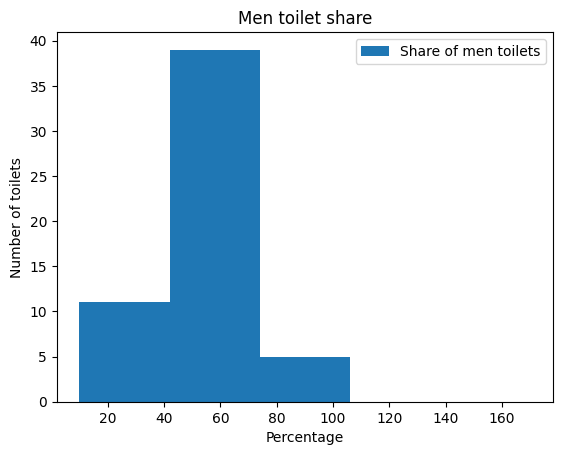

In [ ]:
plot_ratio_distribution(gender_balance.Damen, gender_balance.Herren)
plt.title('Men toilet share');

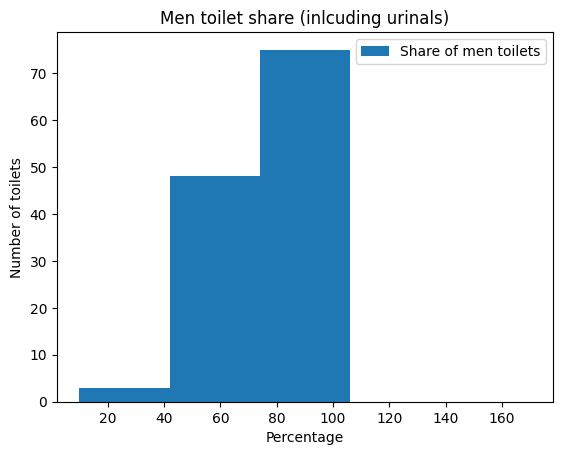

In [ ]:
plot_ratio_distribution(gender_balance.Damen, gender_balance.Herren + gender_balance.Pissoir)
plt.title('Men toilet share (inlcuding urinals)');